In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Arsh@867",
                             database = "ecommerce")

cur = db.cursor()


Basic Queries

1. List all unique cities where customers are located.

In [19]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head

<bound method NDFrame.head of                           0
0                    franca
1     sao bernardo do campo
2                 sao paulo
3           mogi das cruzes
4                  campinas
...                     ...
4114                 siriji
4115    natividade da serra
4116           monte bonito
4117             sao rafael
4118      eugenio de castro

[4119 rows x 1 columns]>

2. Count the number of orders placed in 2017.

In [7]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

data[0][0]

45101

3. Find the total sales per category.

In [8]:
query = """select products.product_category category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)

data = cur.fetchall()

data

[('perfumery', 506738.66),
 ('Furniture Decoration', 1430176.39),
 ('telephony', 486882.05),
 ('bed table bath', 1712553.67),
 ('automotive', 852294.33),
 ('computer accessories', 1585330.45),
 ('housewares', 1094758.13),
 ('babies', 539845.66),
 ('toys', 619037.69),
 ('Furniture office', 646826.49),
 ('Cool Stuff', 779698.0),
 ('HEALTH BEAUTY', 1657373.12),
 ('pet Shop', 311268.97),
 ('General Interest Books', 64694.76),
 ('stationary store', 317440.07),
 ('Watches present', 1429216.68),
 ('PCs', 279121.55),
 ('climatization', 91170.66),
 ('Construction Tools Construction', 241475.63),
 ('sport leisure', 1392127.56),
 ('Bags Accessories', 187151.29),
 ('electronics', 259857.1),
 ('Casa Construcao', 136645.29),
 ('Games consoles', 195480.38),
 ('Fashion Bags and Accessories', 218158.28),
 ('home appliances', 95532.27),
 ('Garden tools', 838280.75),
 ('Agro Industria e Comercio', 118730.61),
 (None, 252801.71),
 ('audio', 60324.62),
 ('technical books', 24915.44),
 ('Construction Tools 

4. Calculate the percentage of orders that were paid in installments.

In [10]:
query = """select (sum(case when payment_installments >= 1 then 1
else 0 end)) / count(*) * 100 from payments"""

cur.execute(query)

data = cur.fetchall()

data[0][0]

Decimal('99.9981')

5. Count the number of customers from each state.

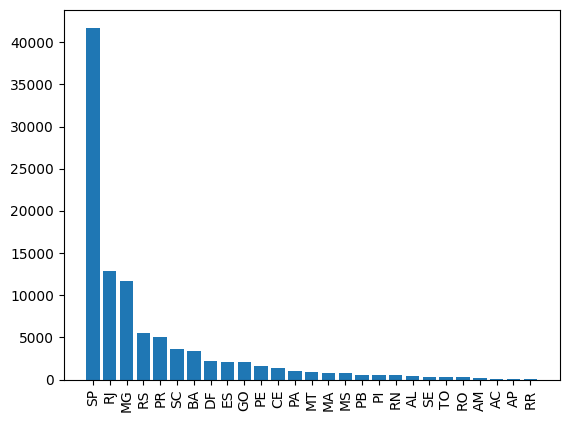

In [18]:
query = """select customer_state ,count(customer_id)
from customers group by customer_state"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending=False)

plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

Intermediate Queries

1. Calculate the number of orders per month in 2018.

In [8]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(query)

data = cur.fetchall()
data

[('July', 6292),
 ('August', 6512),
 ('February', 6728),
 ('June', 6167),
 ('March', 7211),
 ('January', 7269),
 ('May', 6873),
 ('April', 6939),
 ('September', 16),
 ('October', 4)]

2. Find the average number of products per order, grouped by customer city.

In [4]:
query = """with count_per_order as  
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0,1
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


3. Calculate the percentage of total revenue contributed by each product category.

In [17]:
query = """select upper(products.product_category) category,
round((sum(payments.payment_value)/ (select sum(payment_value) from payments)) * 100, 2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
order by sales_percentage desc"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["category", "percentage_distribution"])
df.head()

,category,percentage_distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


4. Identify the correlation between product price and the number of times a product has been purchased.

In [24]:
import numpy as np

query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns= ["category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef ([arr1,arr2])
print ("the correlation between price and orders is", a[0][1])

the correlation between price and orders is -0.10631514167157562


5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [3]:
query = """select *, dense_rank() over (order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0,1,2
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5


Advanced Queries

1. Calculate the moving average of order values for each customer over their order history.

In [7]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns= ["c_id", "o_p_t", "pay", "mov_avg"])
df.head()

,c_id,o_p_t,pay,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


2. Calculate the cumulative sales per month for each year.

In [6]:
query = """select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales 
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value), 2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns= ["year", "month", "pay", "cumulative_pay"])
df.head()

,year,month,pay,cumulative_pay
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


3. Calculate the year-over-year growth rate of total sales.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Arsh@867",
                             database = "ecommerce")

cur = db.cursor()


query = """with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, (payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)* 100 from a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns= ["year", "yoy_percent_growth"])
df.head()

,year,yoy_percent_growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [30]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

5. Identify the top 3 customers who spent the most money in each year.

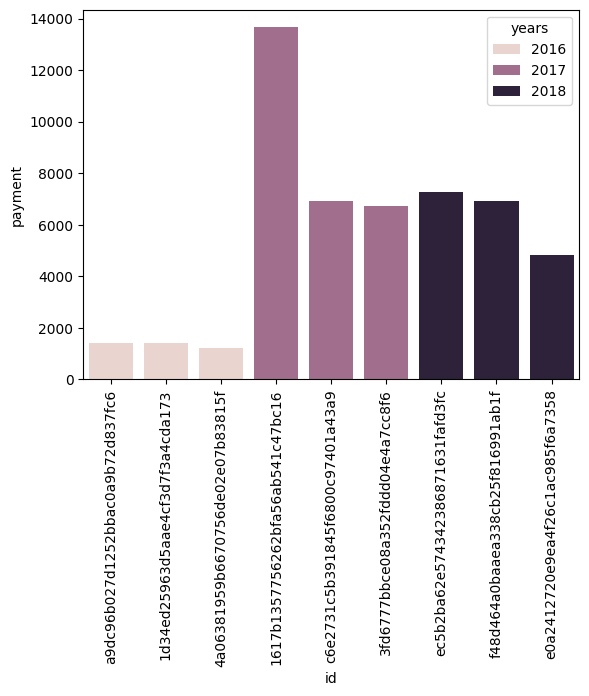

In [35]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), 
orders.customer_id) as a
where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["years", "id", "payment", "rank"])
sns.barplot (x = "id", y = "payment", data= df, hue= "years")
plt.xticks(rotation = 90)
plt.show()